Based on: https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/blob/main/code/Ch9/Chapter%209.ipynb

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from plotnine import *
from statsmodels.datasets import co2

# Data Loading

In [2]:
co2_df=co2.load_pandas().data
co2_df=co2_df.ffill()
print(co2_df.shape)
co2_df.head(5)

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


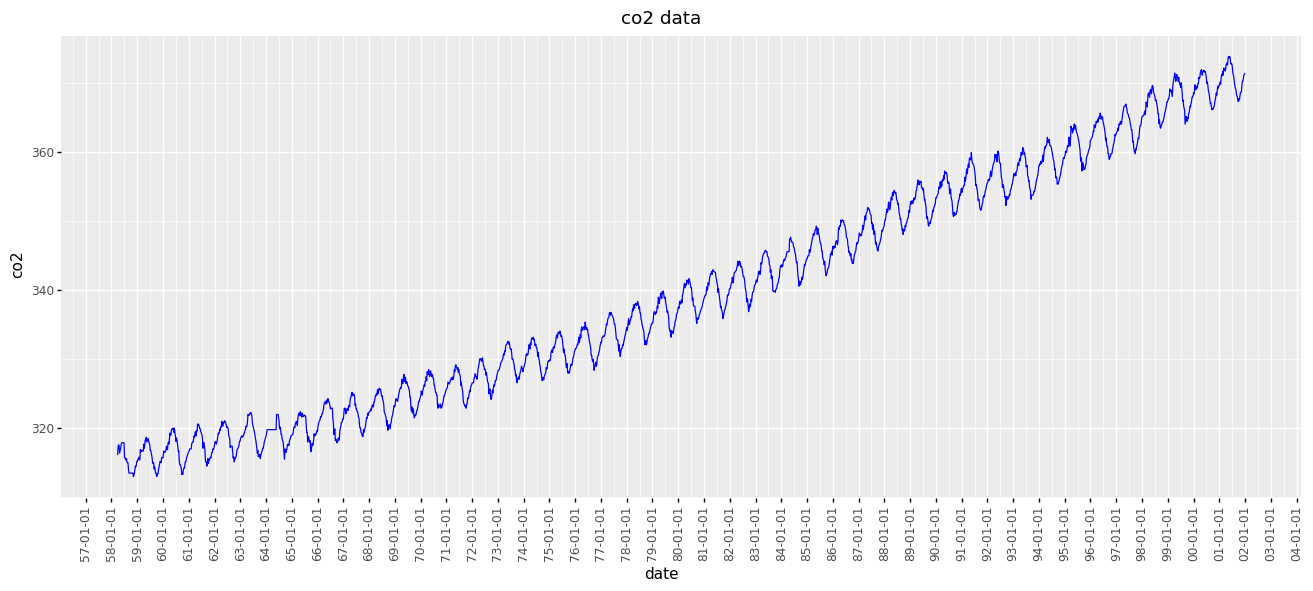

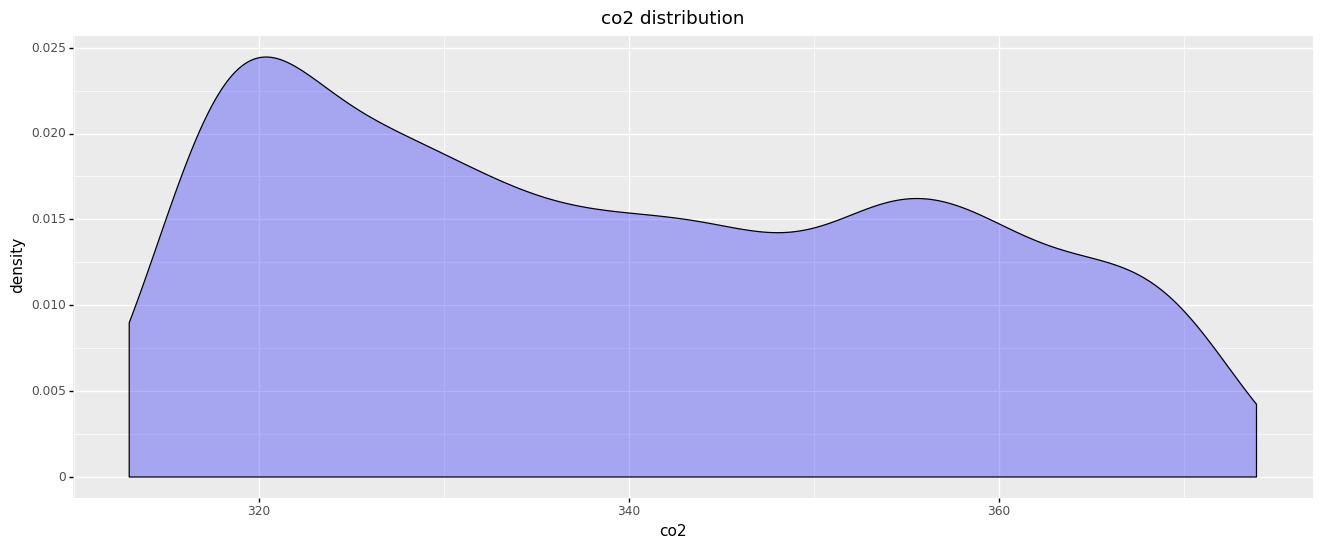

In [3]:
temp_df=co2_df.reset_index().rename(columns={'index':'date'})
print(
    ggplot(temp_df, aes('date','co2'))
    #+geom_point(color='blue')
    +geom_line(color='blue')
    +scale_x_datetime(date_labels=('%y-%m-%d'),date_breaks='1 years')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,6))
    +labs(title='co2 data')
          )
print(
    ggplot(temp_df,aes('co2'))
    +geom_density(fill='blue',alpha=0.3)
    +theme(figure_size=(16,6))
    +labs(title='co2 distribution')
    

)

# 9.4 Detecting Time Series Stationarity 
* Stationarity: constant mean, constant variance, consistent covariance between identical distanced periods (lags)
* adfuller
* kpss

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss

### Pring test results 

In [18]:
def print_results(output,test='adf'):
    
    pval=output[1]
    test_score=output[0]
    lags=output[2]
    
    decision='Non-Stationary'
    
    if test=='adf':
        critical=output[4]
        if pval<0.05:
            decision='Stationary'
    elif test=='kpss':
        critical=output[3]
        if pval>=0.05:
            decision='Stationary'
    
    output_dict={
        'Test Statistic':test_score,
        'p-value':pval,
        'Number of lags':lags,
        'decision':decision
    }
    
    for key,value in critical.items():
        output_dict['Critical Value (%s)' % key]=value
    
    return pd.Series(output_dict,name=test)
    
    

## 9.4.1 Implementation

In [19]:
adf_output=adfuller(co2_df)
kpss_output=kpss(co2_df)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



In [20]:
pd.concat([
    print_results(adf_output,'adf'),
    print_results(kpss_output,'kpss')
],axis=1)

,adf,kpss
Test Statistic,0.046051,8.183188
p-value,0.962179,0.01
Number of lags,27,27
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


In [23]:
adf_output[4].items()

dict_items([('1%', -3.4332519309441296), ('5%', -2.8628219967376647), ('10%', -2.567452466810334)])

In [30]:
for key,value in adf_output[4].items():
    output_dict_test['critical value (%s)' % key]=value

In [31]:
output_dict_test

{'critical value (1%)': -3.4332519309441296,
 'critical value (5%)': -2.8628219967376647,
 'critical value (10%)': -2.567452466810334}

## 9.4.2 Detrending 

### Create functions  

In [32]:
def check_stationarity(df):
    kps=kpss(df)
    adf=adfuller(df)
    
    kpss_pv,adf_pv=kps[1],adf[1]
    kpssh,adfh='Stationary','Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADP Null Hypothesis
        adfh='Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hupothesis
        kpssh='Non Stationary'
    return(kpssh,adfh)

In [ ]:
def plot_comparison(methods,plot_type='line'):
    n=len(methods)//2
    fig,ax=plt.subplots(n,2,sharex=True,figsize=(20,10))
    for i,method in enumerate(methods):
        method.dropna(inplace=True)
        name=[n for n in globals() if globals[n] is method]
        v,r=i//2,i%2
        
        kpss_s,adf_s=check_stationarity(method)
        
        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}'
                   )
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r],legend=False)